# Seq2Seq用于电力负荷预测

In [1]:
# prediction by seq2seq model which consists of LSTM-LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sqlalchemy import create_engine
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

## 导入数据

In [3]:
# load data
url = '../dataset_0101110000.csv'
data = pd.read_csv(url, sep=',', index_col='time')

## 归一化

In [4]:
# 归一化
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    normalized_data = MinMaxScaler().fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[['load']])
    return normalized_data, scaler_y

## 监督学习数据集

In [5]:
# build supervised data
def Series_To_Supervise(data, seq_len, target_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
#     pdb.set_trace()
    dim_0 = data.shape[0] - seq_len
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data[i: i+seq_len]
        y[i] = data[i+seq_len-target_len:i+seq_len, y_col_index]
    print("Supervised Train Data: Shape of x: {}, Shape of y: {}".format(x.shape, y.shape))
    return x, y

def Series_To_Supervise_Test(data, seq_len, target_len, y_col_index):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of sequence
    :y_col_index: index of column which acts as output
    :return: return two ndarrays-- input and output in format suitable to feed to LSTM
    """
    dim_0 = int((data.shape[0] - seq_len)/24)+1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(0, dim_0):
        x[i] = data[i*24: i*24+seq_len]
        y[i] = data[i*24+seq_len-target_len:i*24+seq_len, y_col_index]
    print("Supervised Test Data: Shape of x: {}, Shape of y: {}".format(x.shape, y.shape))
    return x, y

## 五折交叉验证

In [6]:
# 5-fold cross-validation
def split_dataset(X, Y, n_split=5):
    """
    X: original feature, size * 72 * features
    Y: labels, size * 1
    return: list of train_x, test_x, train_y, test_y
    """
    kf = KFold(n_splits=n_split, shuffle=True, random_state=1)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in kf.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, valid_x_list, train_y_list, valid_y_list

## 定义模型

In [7]:
# define lstm_encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTMEncoder, self).__init__()
        # 初始化hidden_state参数
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # 定义层
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        
        lstm_out, hidden = self.lstm(x, hidden)
        return lstm_out, hidden
    
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                      torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [8]:
# define attn_lstm_decoder
class AttnLSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size=1, n_layers=1, drop_prob=0.1, seq_len=48):
        super(AttnLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        # 计算attention
        self.seq_len = seq_len
        
        self.embedding = nn.Linear(self.input_size, self.hidden_dim * self.n_layers)
        self.attn = nn.Linear(self.hidden_dim * self.n_layers * 2, self.seq_len)
        self.attn_combine = nn.Linear(self.hidden_dim * (self.n_layers + 1), self.hidden_dim)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_dim, self.output_size)
    
    def forward(self, input, hidden, encoder_outputs):
        """
        :input size(batch_size, 1, input_size)
        :hidden size(batch_size, 1, hidden_dim)
        :encoder_outputs size(batch_size, seq_len, hidden_dim)
        """
        embedded = self.embedding(input)
        
        # flat hidden to calculte weights
        # pdb.set_trace()
        hidden_flat = hidden[0].transpose(0, 1)
        hidden_flat = hidden_flat.contiguous().view(hidden_flat.shape[0], 1, -1)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden_flat), 2)), dim=2)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)
        
        output = torch.cat((embedded, attn_applied), 2)
        output = self.attn_combine(output)
        output = F.relu(output)
        
        output, hidden = self.lstm(output, hidden)        
        
        output = self.out(output)      
        
        return output, hidden        

## 训练模型

In [9]:
# train the model 
def train_model(train_x_list, train_y_list, valid_x_list, valid_y_list, input_size=23, hidden_dim=70, n_layers=1,
                seq_len=48, target_len=24, number_epochs=40, batch_size=512, teacher_forcing_ratio=0.5,
                lr=0.01, training_prediction='teacher_forcing', dynamic_tf=False):
    encoder = LSTMEncoder(input_size, hidden_dim, n_layers)
    decoder = AttnLSTMDecoder(input_size, hidden_dim, n_layers=n_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    criterion = nn.MSELoss()
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    valid_loss_min = np.Inf
    for i in range(5):
        print('train dataset {}'.format(i))
        train_x = train_x_list[i]
        train_y = train_y_list[i]
        valid_x = valid_x_list[i]
        valid_y = valid_y_list[i]
        train_dataset = TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        train_losses = list()
  
        num_without_imp = 0
        
        y_index = train_x.shape[2] - 1
        #train
        for epoch in range(1, number_epochs + 1):
            loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = torch.zeros(batch_size, target_len).to(device)
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                # encoder
                input_tensor = inputs[:, 0:seq_len, :]
                target_tensor = inputs[:, seq_len:, :]
                encoder_outputs, encoder_hidden = encoder(input_tensor)
                # decoder
                decoder_input = inputs[:, seq_len-1, :].unsqueeze(1)
                decoder_hidden = encoder_hidden
                
                if training_prediction == 'recursive':
                    # predict recursively
                    for t in range(target_len):
                        # pdb.set_trace()
                        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                        outputs[:, t] = decoder_output.squeeze()
                        decoder_input = torch.cat((target_tensor[:, t, :-1].unsqueeze(1), decoder_output.detach()), 2)
                
                if training_prediction == 'teacher_forcing':
                    # use teacher forcing
                    if random.random() < teacher_forcing_ratio:
                        for t in range(target_len):
                            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                            outputs[:, t] = decoder_output.squeeze()
                            decoder_input = target_tensor[:, t, :].unsqueeze(1)
                    # predict recurisively
                    else:
                        for t in range(target_len):
                            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                            outputs[:, t] = decoder_output.squeeze()
                            decoder_input = torch.cat((target_tensor[:, t, :-1].unsqueeze(1), decoder_output.detach()), 2)
                
                if training_prediction == 'mixed_teacher_forcing':
                    # predict using mixed teacher forcing
                    for t in range(target_len):
                        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                        outputs[:, t] = decoder_output.squeeze()
                        # predict with teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            decoder_input = target_tensor[:, t, :].unsqueeze(1)
                                
                        # predict recursively 
                        else:
                            decoder_input = torch.cat((target_tensor[:, t, :-1].unsqueeze(1), decoder_output.detach()), 2)
                loss = criterion(outputs, labels)
                train_losses.append(loss.item)
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                
                # eval
                if i % 5 == 0:
                    # if num_without_imp > 60:
                    #     return encoder, decoder
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    encoder.eval()
                    decoder.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        out = torch.zeros(batch_size, target_len).to(device)
                        # encoder
                        input_tensor = inp[:, 0:seq_len, :]
                        target_tensor = inp[:, seq_len:, 0:-1]
                        encoder_outputs, encoder_hidden = encoder(input_tensor)
                        # decoder
                        decoder_input = inp[:, seq_len-1, :].unsqueeze(1)
                        decoder_hidden = encoder_hidden
                        # predict recuisively
                        for t in range(target_len):
                            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                            out[:, t] = decoder_output.squeeze()
                            decoder_input = torch.cat((target_tensor[:, t, :].unsqueeze(1), decoder_output.detach()), 2)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())
                    encoder.train()
                    decoder.train()
                    loop.set_description("Epoch: {}/{}...".format(
                        epoch, number_epochs))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(encoder.state_dict(), "encoder_state_dict.pt")
                        torch.save(decoder.state_dict(), "decoder_state_dict.pt")
                        valid_loss_min = np.mean(valid_losses)
    return encoder, decoder

## 测试模型

In [10]:
# test the model
def test_model(encoder, decoder, test_x, test_y, batch_size, seq_len, target_len, scaler):
    # pdb.set_trace()
    test_dataset = TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    encoder.load_state_dict(torch.load('encoder_state_dict.pt'))
    decoder.load_state_dict(torch.load('decoder_state_dict.pt'))
    y_pred = list()
    y_true = list()
    y_index = test_x.shape[2] - 1
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            outputs = torch.zeros(batch_size, target_len).to(device)
            # encoder
            input_tensor = inputs[:, 0:seq_len, :]
            target_tensor = inputs[:, seq_len:, :]
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            # decoder
            decoder_input = inputs[:, seq_len-1, :].unsqueeze(1)
            decoder_hidden = encoder_hidden
            # predict recursively
            for t in range(target_len):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
                outputs[:, t] = decoder_output.squeeze()
                decoder_input = torch.cat((target_tensor[:, t, :-1].unsqueeze(1), decoder_output.detach()), 2)
            y_pred = y_pred + outputs.view(-1).cpu().numpy().tolist()
            y_true = y_true + labels.view(-1).cpu().numpy().tolist()
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    load_true = scaler.inverse_transform(np.expand_dims(y_true, axis=1))
    load_pred = scaler.inverse_transform(np.expand_dims(y_pred, axis=1))
    MAPE = np.mean(np.abs(load_true-load_pred)/load_true)
    MAE = np.mean(np.abs(load_true-load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true-load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## 超参数定义

In [11]:
# model configs
def Model_Configs():
    batch_sizes = [512]
    n_layers = [1]
    lrs = [0.01]
    hidden_dims = [70]
    configs = list()
    for i in batch_sizes:
        for j in n_layers:
            for k in lrs:
                for l in hidden_dims:
                    configs.append([i, j, k, l])
    return configs

## 主函数

In [12]:
def main(n_split=5, seq_len=48, target_len=24, plot=False):
    normalized_data, scaler_y = normalization(data)
    train_data = normalized_data
    test_data = normalized_data[-3000:]
    y_index = normalized_data.shape[1] - 1
    num_features = normalized_data.shape[1]
    x, y = Series_To_Supervise(train_data,
                               seq_len=seq_len + target_len,
                               target_len=target_len,
                               y_col_index=y_index)
    train_x_list, valid_x_list, train_y_list, valid_y_list = split_dataset(
        x, y, n_split=n_split)
    test_x, test_y = Series_To_Supervise_Test(test_data,
                                              seq_len=seq_len + target_len,
                                              target_len=target_len,
                                              y_col_index=y_index)

    configs = Model_Configs()
    MAPE_list = list()
    MAE_list = list()
    RMSE_list = list()
    for config in configs:
        batch_size = config[0]
        n_layer = config[1]
        lr = config[2]
        hidden_dim = config[3]
        print(
            "Model Config: batch_size--{}, n_layer--{}, lr--{}, hidden_dims--{}"
            .format(batch_size, n_layer, lr, hidden_dim))

        while (1):

            encoder, decoder = train_model(
                train_x_list,
                train_y_list,
                valid_x_list,
                valid_y_list,
                input_size=num_features,
                hidden_dim=hidden_dim,
                batch_size=batch_size,
                n_layers=n_layer,
                lr=lr,
                seq_len=seq_len,
                target_len=target_len,
                training_prediction='teacher_forcing')
            (MAPE, MAE, RMSE, load_pred,
             load_true) = test_model(encoder,
                                     decoder,
                                     test_x,
                                     test_y,
                                     batch_size=1,
                                     seq_len=seq_len,
                                     target_len=target_len,
                                     scaler=scaler_y)
            if MAPE < 0.1:
                break
        MAPE_list.append(MAPE)
        MAE_list.append(MAE)
        RMSE_list.append(RMSE)
    return (MAPE_list, MAE_list, RMSE_list, load_pred, load_true, encoder,
            decoder)

## 运行

In [14]:
(MAPE_list, MAE_list, RMSE_list, load_pred, load_true, encoder, decoder) = main()

Supervised Train Data: Shape of x: (31587, 72, 23), Shape of y: (31587, 24)
Supervised Test Data: Shape of x: (123, 72, 23), Shape of y: (123, 24)
Model Config: batch_size--512, n_layer--1, lr--0.01, hidden_dims--70
train dataset 0


Epoch: 40/40...: 100%|██████████| 49/49 [00:14<00:00,  3.45it/s, train_loss=0.0011, valid_loss=0.00113]  


train dataset 1


Epoch: 40/40...: 100%|██████████| 49/49 [00:14<00:00,  3.50it/s, train_loss=0.00029, valid_loss=0.000737] 


train dataset 2


Epoch: 40/40...: 100%|██████████| 49/49 [00:09<00:00,  4.95it/s, train_loss=0.000573, valid_loss=0.000665]


train dataset 3


Epoch: 40/40...: 100%|██████████| 49/49 [00:12<00:00,  3.94it/s, train_loss=0.000309, valid_loss=0.000297]


train dataset 4


Epoch: 40/40...: 100%|██████████| 49/49 [00:06<00:00,  7.63it/s, train_loss=8.49e-5, valid_loss=0.000208] 


In [16]:
MAPE_list, MAE_list, RMSE_list

([0.015522965697851209], [194.5411310854327], [265.15881628882863])

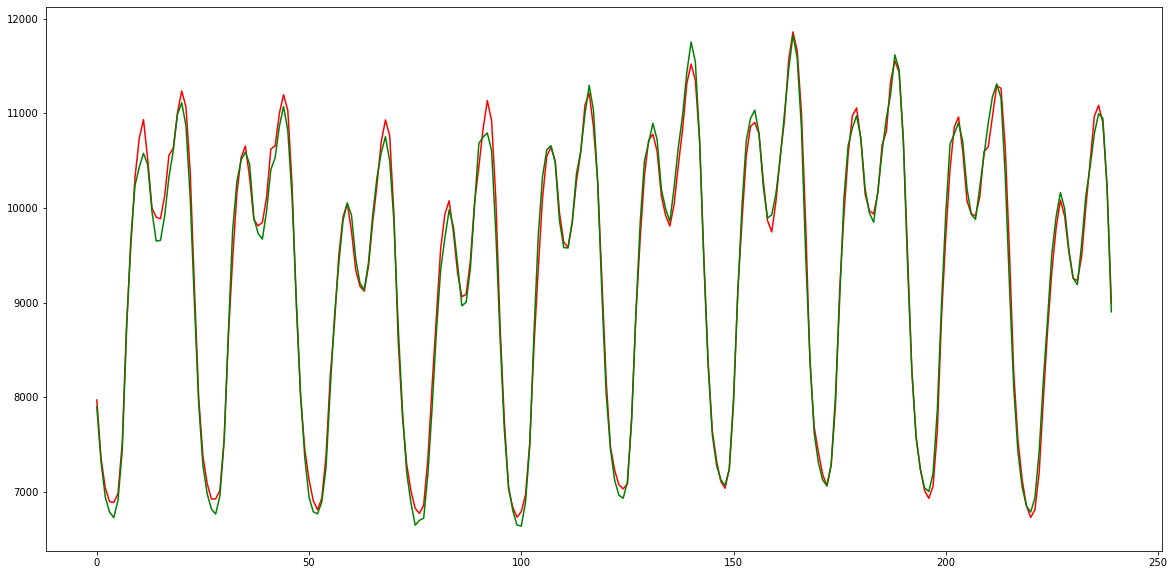

In [17]:
plt.figure(figsize=(20,10))
plt.plot(load_pred[:240], 'r')
plt.plot(load_true[:240], 'g')

In [ ]:
np.save('./load_pred_seq2seq.npy', load_pred)
np.save('./load_true_seq2seq.npy', load_true)
torch.save(encoder.state_dict(), "encoder_state_dict.pt")
torch.save(decoder.state_dict(), "decoder_state_dict.pt")